In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
import loader

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [8]:
np.random.random_integers(400000, 2000000,6)

array([1887113,  913096,  414230,  707345,  452712, 1799036])

In [5]:
# train_dict = loader.load_training_data()

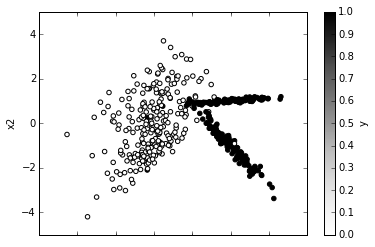

In [25]:
from sklearn.datasets import make_classification

X, y = make_classification(500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0)
pd.DataFrame({"x1":X[:,0], "x2":X[:,1],"y":y}).plot(kind='scatter',x='x1', y='x2', c='y')
y = pd.get_dummies(y).values

In [7]:
def initialize_layer(input_dim, output_dim, seed=100):
    np.random.seed(seed)
    col_shape = (output_dim,)
    z = np.random.normal(0, 0.01, col_shape)
    y = np.random.normal(0, 0.01, col_shape)
#     b = np.random.normal(0, 0.01, col_shape)
    b = np.ones(col_shape)
    w = np.random.normal(0, 0.01, (input_dim, output_dim))
    return z, b, y, w

def shape_check(checks):
    for k, v in checks.items():
        try:
            assert k == v.shape
        except AssertionError:
            print("ERROR")
            print(k, v.shape)
            raise AssertionError
            
def predictNN(transformations, X):
    temp = X
    for trans in transformations:
        if callable(trans):
            temp = trans(temp)
        else:
            temp = temp.dot(trans)
    return temp.argmax(axis=1)

def scoreNN(transformations, X, y):
    preds = predictNN(transformations, X)
    return sum(preds != y.argmax(axis=1))

In [19]:
def squared_error(y, y_hat):
    return (y - y_hat).dot((y - y_hat))

def squared_error_der(y, y_hat):
    return -(y - y_hat)

def t(z):
    return np.tanh(z)

def t_der(z):
    return 1 - t(t(z))

def g(z):
    return (1 / (1 - np.exp(-z)))

def g_der(z):
    return g(z) * (1 - g(z))

def dEdz2(z_2, y_2, y, loss_der):
    return np.multiply(g_der(z_2), loss_der(y, y_2))

def dEdz1(z_1, w_2, dEdz2_cached):
    return np.diag(t_der(z_1)).dot(w_2).dot(dEdz2_cached)

def l2_deriv(y_1, dEdz2_cached):
    return np.outer(y_1, dEdz2_cached.T)

def l1_deriv(y_0, dEdz1_cached):
    return np.outer(y_0, dEdz1_cached.T)

In [20]:
def trainNN(XTrain, yTrain, **kwargs):
    hidden_layer_dim = kwargs.get("hidden_layer_dim", 50)
    output_layer_dim = kwargs.get("output_layer_dim", 2)
    num_iters = kwargs.get("num_iters", 5)
    eta = kwargs.get("eta", 1)
    
    z_1, b_1, y_1, w_1 = initialize_layer(len(XTrain[0,:]), hidden_layer_dim)
    z_2, b_2, y_2, w_2 = initialize_layer(hidden_layer_dim, output_layer_dim)
    
    training_errors = []
    iters = []
    losses = []
    for _ in range(num_iters):
        ex_index = np.random.choice(len(XTrain), 1)
        y_0 = XTrain[ex_index].reshape(2,)
        y = yTrain[ex_index].reshape(2,)
        
        # layer 1
        y_0.dot(w_1, out=z_1)
        z_1 = z_1 + b_1
        y_1 = t(z_1)
#         shape_check({(200, ):z_1, (784, 200):w_1, (200, ):y_1})
        
        # layer 2
        y_1.dot(w_2, out=z_2)
        z_2 = z_2 + b_2
        y_2 = g(z_2)
#         shape_check({(10, ):z_2, (200, 10):w_2, (10, ):y_2})
        
        #cache
        dEdz2_cache = dEdz2(z_2, y_2, y, squared_error_der)
#         shape_check({(10,):dEdz2_cache})
        dEdz1_cache = dEdz1(z_1, w_2, dEdz2_cache)
#         shape_check({(200,):dEdz1_cache})


        # backprop
        l1_d = l1_deriv(y_0, dEdz1_cache)
#         shape_check({(784, 200):l1_d})
        l2_d = l2_deriv(y_1, dEdz2_cache)
#         shape_check({(200, 10): l2_d})

        
        # update
        w_1 -= eta * l1_d
        w_2 -= eta * l2_d
        b_1 -= eta * np.sum(dEdz1_cache, axis=0)
        b_2 -= eta * np.sum(dEdz2_cache, axis=0)
        


        if _ % 10 == 0: 
            sequence = [w_1, lambda x: x + b_1, t, w_2, lambda x: x+b_2, g]
            training_error = scoreNN(sequence, XTrain, yTrain)
            loss = squared_error(y, y_2)
            training_errors.append(training_error)
            losses.append(loss)
            iters.append(_)
            if _ % 4000 == 0:
                print("-"*30, "Iter: %i, Train Errors: %i" % (_, training_error))
                if kwargs.get("debug_full", False):
                    print("Mean W1 Weights:", w_1.mean())
                    print("Mean W2 Weights:", w_2.mean())
                    print("")
                    print("Mean Z1:", (z_1).mean())
                    print("Mean Z2:", (z_2).mean())
                    print("")
                    print("Mean L1:", (l1_d).mean())
                    print("Mean L2:", (l2_d).mean())
                    print("")
                    print("Mean W1 Update:", (eta * l1_d).mean())
                    print("Mean W2 Update:", (eta * l2_d).mean())
                    print("-"*30)
                
    pd.DataFrame({"training errors": training_errors, 
                  "iters": iters, 
                  'loss':loss}).plot(x='iters', ylim=(0,200))
    return {
        "model":[w_1, lambda x: x + b_1, t, w_2, lambda x: x + b_2, g],
        "training errors": training_errors,
        "iters": iters
        }

------------------------------ Iter: 0, Train Errors: 250
------------------------------ Iter: 4000, Train Errors: 250
------------------------------ Iter: 8000, Train Errors: 250
------------------------------ Iter: 12000, Train Errors: 250
------------------------------ Iter: 16000, Train Errors: 250


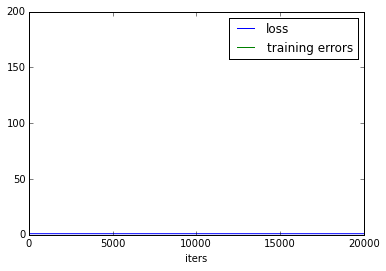

In [21]:
# %debug
model = trainNN(X, y
        , num_iters=20000#, debug_full=True
       )

In [ ]:
model = trainNN(x1, y1
        , num_iters=20000
#         , num_iters=5000, debug_full=True
       )

In [2]:
5000 / 500

10.0